[7 Wonders](https://rprod.com/index.php?page=description-22)

Simulating game and cheking personal record if it's any different from random chance.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import random
from collections import Counter

My game record playing [7 Wonders on Android](https://play.google.com/store/apps/details?id=com.rprod.sevenwonders&hl=en_GB)

In [2]:
# Game record

# Games by count of number of players
mygames = {
    3: 3,
    4: 4,
    5: 7,
    6: 2,
    7: 13,
}

# Number of final positions
myrecord = {
    1: 4,
    2: 6,
    3: 2,
    4: 5,
    5: 6,
    6: 4,
    7: 2
}

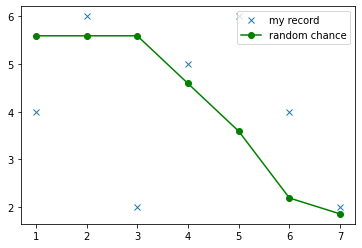

In [3]:
def means(games):
    """ Expected win count based on game play count if all random"""
    res = []
    for pos in range(1, 8):
        r = 0
        for z in games:
            if z >= pos:
                r += games[z] * 1/z
        res += [r]
    return np.array(res)

mymeans = means(mygames)

my_labels, my_values = zip(*myrecord.items())

plt.plot(my_labels, my_values, 'x', label="my record")
plt.plot(np.arange(1, 8), mymeans, 'o-', color='g', label="random chance")
plt.legend()

Use [Chi-squared test](https://en.wikipedia.org/wiki/Chi-squared_test) with the hypothesis that my game record comes from random chance.

In [4]:
x = stats.chisquare(np.array([myrecord[pos] for pos in sorted(myrecord)]), f_exp=mymeans)
print(f"chi^2: {x.statistic:.3f}, p-value: {x.pvalue:.3f}")
pthreshold = 0.05
if x.pvalue < pthreshold:
    print(f"=> Rejecting the null-hypothesis with {ptreshold} threshold.")
else:
    print(f"=> Can't reject null-hypothesis of random outcomes from Poisson binomial distribution.")

chi^2: 5.948, p-value: 0.429
=> Can't reject null-hypothesis of random outcomes from Poisson binomial distribution.


Run simulations of the game as a random chance outcome.
The game counts the same as the original record (the distribution of 3, 4, ... player games), and the outcome of each is by random chance only.

In [5]:
n_sims = 32000
random.seed(3)

d = {p: [] for p in range(1, 8)}

def singlegame(players):
    return random.randint(1, players)

def manygame(games):
    c = {p: 0 for p in range(1, 8)}
    for g in games.items():
        for p in [singlegame(g[0]) for _ in range(g[1])]:
            c[p] += 1
    return c

for n in range(n_sims):
    g = manygame(mygames)
    labels, values = zip(*g.items())
    for p in g.items():
        d[p[0]] += [p[1]]

The expected distribution is Poisson binomial, check against that.

In [6]:
def C(n):
    return np.exp(2j*np.pi/(n+1))

def pmf(k, pos, games):
    """ Implementing the Poission binomial probability mass function
    based on Fourier transforms.
    """
    total = 0
    n = 0
    for z in games:
        if z >= pos:
            n += games[z]
    cn =C(n)
    for l in range(0, n+1):
        cl = cn**(-l*k)
        for z in games:
            if z >= pos:
                cl *= (1 + (cn**l -1)*(1/z))**games[z]
        total += cl
    return abs(total/(n+1))


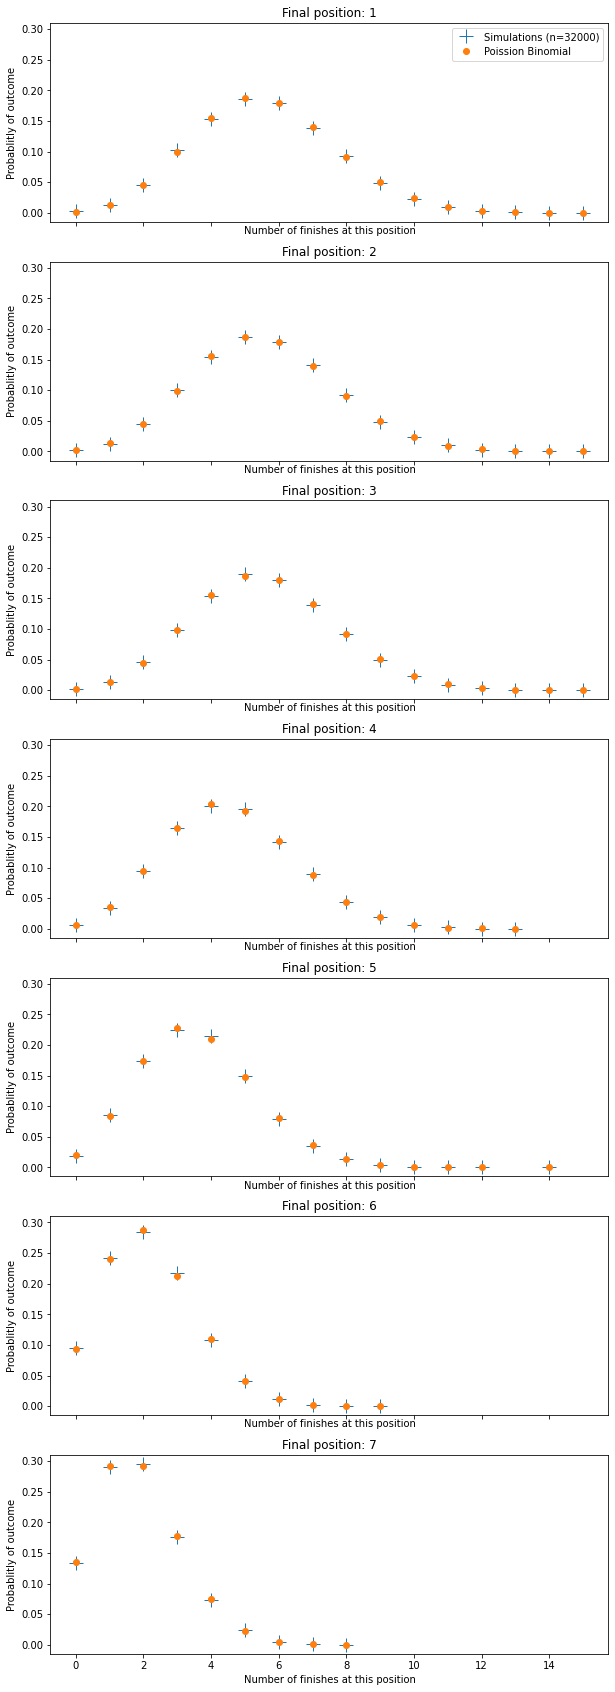

In [7]:
fig, ax = plt.subplots(7, 1, figsize=(10, 30), sharex=True, sharey=True)

for pos in range(1, 8):
    posax = ax[pos-1]

    cx = Counter(d[pos])
    x = sorted(cx.keys())
    y = np.array([cx[i]/n_sims for i in x])

    posax.plot(x, y, '+', markersize=14, label=f"Simulations (n={n_sims})")
    y = np.array([pmf(k, pos, mygames) for k in x])
    posax.plot(x, y, 'o', label='Poission Binomial')
    posax.set_title(f"Final position: {pos}")
    posax.set_ylabel("Probablitly of outcome")
    if (pos == 1):
        posax.legend()
    posax.set_xlabel("Number of finishes at this position")
